In [29]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [32]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data\\anchor\\ba6f4598-e328-11ef-8cb9-60189528fa7a.jpg'

In [33]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        print("Image has been saved to Anchor folders")

    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        print("Image has been saved to Positive folders")
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

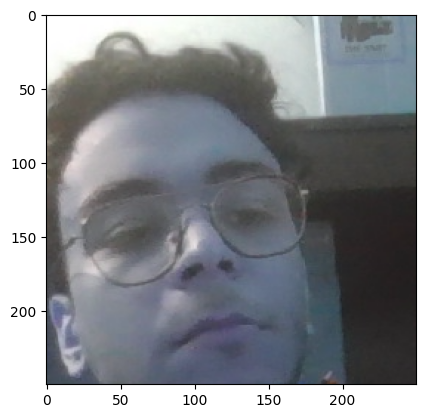

In [34]:
plt.imshow(frame)


In [35]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(40)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(40)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [36]:
dir_test = anchor.as_numpy_iterator()


In [37]:
print(dir_test.next())


b'data\\anchor\\27c96cec-e2d3-11ef-9020-60189528fa7a.jpg'


In [38]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    
    # Return image
    return img

In [39]:
img = preprocess('data\\anchor\\46b5e6d4-e2ce-11ef-849b-60189528fa7a.jpg')


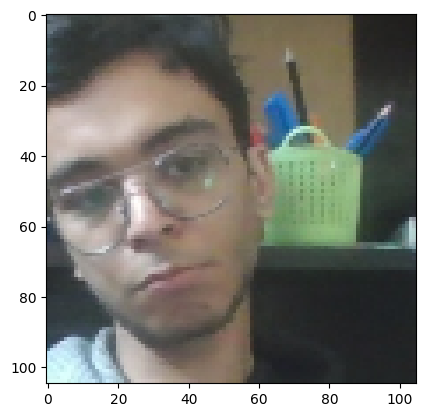

In [40]:
plt.imshow(img)

In [41]:
img.numpy().min() 


0.05565982

In [42]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [43]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [44]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple


(b'data\\anchor\\113661e4-e2d3-11ef-99cd-60189528fa7a.jpg',
 b'data\\positive\\21438ef4-e2ce-11ef-811a-60189528fa7a.jpg',
 1.0)

In [45]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [46]:
res = preprocess_twin(*exampple)


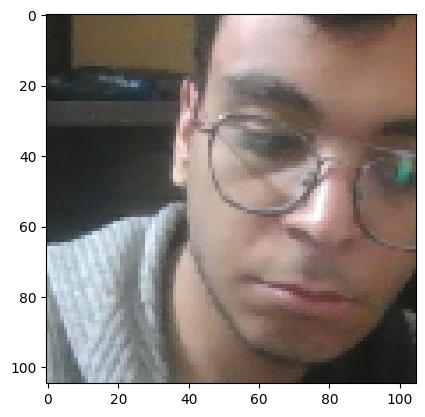

In [56]:
plt.imshow(res[0])


In [48]:
res[2]

1.0

In [49]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [50]:
samples = data.as_numpy_iterator()
samp = samples.next()

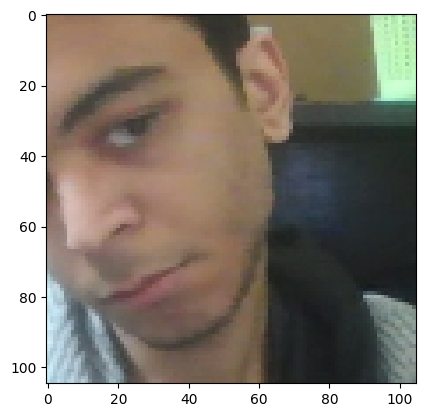

In [51]:
plt.imshow(samp[1])

In [52]:
samp[2]

1.0

In [53]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [54]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [61]:
inp = Input(shape=(105,105,3), name='input_image')
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [60]:
conv_1 = Conv2D(64, (10,10), activation='relu')(inp)
conv_1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_2')>